In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models

import tcremb.metrics as metrics
import tcremb.TCRemb as TCRemb

import benchmark.models_tcrdist as models_tcrdist

In [4]:
tcr_columns_paired = {'TRA':['a_cdr3aa','TRAV','TRAJ'],'TRB':['b_cdr3aa','TRBV','TRBJ']}
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

# Clustering

## VDJdb V10-V1000

In [5]:
samples_n = [10,50,100,500,1000]
samples_n_b = [10,50,100]
#samples_n = [10]

In [6]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
tcremb_res_raw_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3 vs TRCemb

In [9]:
eps_l = [0.1,0.5,1,5,10,100,750,900,1000, 1100,1200,1300,1400,1500]

In [10]:
chain = 'TRA_TRB'
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_V{i}.csv',sep='\t')
    vdjdb_v['TRAV']= vdjdb_v['TRAV'] + '*01'
    vdjdb_v['TRBV']= vdjdb_v['TRBV'] + '*01'
    vdjdb_v['TRAJ']= vdjdb_v['TRAJ'] + '*01'
    vdjdb_v['TRBJ']= vdjdb_v['TRBJ'] + '*01'
    vdjdb_v['TRAV'] = vdjdb_v['TRAV'].str.replace('DV','/DV')
    
    if chain == 'TRA_TRB':
        vdjdb_v = vdjdb_v[~(vdjdb_v['a_cdr3aa'].isna()|vdjdb_v['b_cdr3aa'].isna())].drop_duplicates(tcr_columns_paired['TRA'] + tcr_columns_paired['TRB']).reset_index(drop=True)
    else:
        vdjdb_v = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()].drop_duplicates(list(tcr_columns_paired[chain])).reset_index(drop=True)
    
    print(len(vdjdb_v))
    
    tcrdist_res_v[chain] = models_tcrdist.run_tcrdist3_set(vdjdb_v,chain, f'V{i}', eps=eps_l)
    #tcrdist_res[chain] = models_tcrdist.run_tcrdist3(vdjdb_data_tcrdist3)

5558

*** Tcrdist3 clustering 5558 TRA_TRB chains 


In [11]:
for i in eps_l:
    print(metrics.get_clustermetrics(tcrdist_res_v[chain][i], 'antigen.epitope'))

{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0244, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.4}
{'purity': 0.99, 'retention': 0.21, 'consistency': 0.0048, 'ami': 0.98, 'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'mean_clusts

In [24]:
chain = 'TRA_TRB'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 34273
data/data_preped/VDJdb_data_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_V10.csv --runname compare_V10 --chain TRA_TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


Traceback (most recent call last):
  File "/home/ykremlyakova/projects/tcr_emb/tcremb_run.py", line 17, in <module>
    import tcremb.TCRemb as TCRemb
  File "/home/ykremlyakova/projects/tcr_emb/tcremb/TCRemb.py", line 9, in <module>
    from mir.common import parser, Repertoire, SegmentLibrary
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/__init__.py", line 3, in <module>
    from .segments import Segment, SegmentLibrary
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/segments.py", line 72, in <module>
    class SegmentLibrary:
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/segments.py", line 162, in SegmentLibrary
    def get_or_create(self, s: str | Segment,
TypeError: unsupported operand type(s) for |: 'type' and 'type'


Elapsed time: 8.549524068832397 seconds.


In [29]:
## work with results
chain = 'TRA_TRB'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~(vdjdb_v[tcr_columns_paired['TRA'][0]].isna()&vdjdb_v[tcr_columns_paired['TRB'][0]].isna())][['data_id',tcr_columns_paired['TRA'][0],tcr_columns_paired['TRA'][2],tcr_columns_paired['TRB'][0],tcr_columns_paired['TRB'][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 5044
0.963963963963964
{'purity': 0.96, 'retention': 0.05, 'consistency': 0.0082, 'ami': 0.94, 'precision': 0.96, 'recall': 0.96, 'f1-score': 0.96, 'mean_clustsize': 6.56, 'method': 'TCRemb'}


In [5]:
chain='TRA_TRB'
i=10
v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')
run_name=f'compare_V{i}'

In [6]:
unique_clonotypes=True
tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb.tcremb_clonotypes(chain, unique_clonotypes=unique_clonotypes)
tcremb.tcremb_dists(chain)
tcremb.tcremb_pca(chain)
tcremb.tcremb_tsne(chain)

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [7]:
method= run_name + '_DBSCAN'
dbscan = TCRemb.TCRemb_clustering('DBSCAN')
metrics_dbscan = {}

In [8]:

metrics_dbscan[label]={}

In [9]:

#coef = 0.85
#model = DBSCAN(eps=round(float(eps_by_knee_dict[chain]['knee'])*coef,2), min_samples=2)
dbscan.clstr(chain,tcremb, label, on_pca=False)

purity:0.9802955665024631


In [10]:
df = tcremb.annot_input[chain].merge(dbscan.clstr_labels[chain], how='left')
df['is_cluster'] = df['is_cluster'].fillna(0)
metrics_dbscan[label][chain] = metrics.get_clustermetrics(df, label)
metrics_dbscan[label][chain]['total pairs TCR-epitope'] = len(tcremb.annot[chain])
metrics_dbscan[label][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label][chain]['total unique epitopes'] = str(len(tcremb.annot[chain].drop_duplicates(label)))
metrics_dbscan[label][chain]['label']=label
metrics_dbscan[label][chain]


{'purity': 0.98,
 'retention': 0.31,
 'consistency': 0.0102,
 'ami': 0.96,
 'precision': 0.98,
 'recall': 0.98,
 'f1-score': 0.98,
 'mean_clustsize': 5.85,
 'total pairs TCR-epitope': 4572,
 'total unique TCRs': '4572',
 'total unique epitopes': '104',
 'label': 'antigen.epitope'}

### ismart

In [7]:
## Run ismart
chain = 'TRA'
ismart_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[chain][i] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
Clustering 10288 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.365003
Performing pairwise alignment
Number of pairs to be processed: 606770
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
Done! Time Elapsed 9.912793
Total time elapsed: 13.397677
Maximum memory usage: 0.109144 MB
Elapsed time: 13.592625856399536 seconds.
TCR-epitope paires count in V50 dataset: 9281
Clusterin

In [8]:
## Run ismart
chain = 'TRB'
ismart_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[chain][i] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
Clustering 21991 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 5.778450
Performing pairwise alignment
Number of pairs to be processed: 2553420
Processed 1000000 pairs. Elapsed time 16.343802
Processed 2000000 pairs. Elapsed time 34.883119
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 49.190071
Total time elapsed: 52.515363
Maximum m

In [9]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    # 200524 ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    ismart_res_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    # 200524printvdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    # 200524printvdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    # 200524printvdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    # 200524printprint(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    # 200524ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    # 200524ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    # 200524print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    # 200524printprint(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

{'purity': 0.86, 'retention': 0.2, 'consistency': 0.0027, 'ami': 0.74, 'precision': 0.86, 'recall': 0.86, 'f1-score': 0.86, 'mean_clustsize': 3.37, 'method': 'iSmart'}
{'purity': 0.88, 'retention': 0.2, 'consistency': 0.0052, 'ami': 0.75, 'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'mean_clustsize': 3.45, 'method': 'iSmart'}
{'purity': 0.89, 'retention': 0.19, 'consistency': 0.0071, 'ami': 0.75, 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89, 'mean_clustsize': 3.45, 'method': 'iSmart'}
{'purity': 0.94, 'retention': 0.19, 'consistency': 0.0315, 'ami': 0.73, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.87, 'method': 'iSmart'}
{'purity': 0.95, 'retention': 0.17, 'consistency': 0.0452, 'ami': 0.63, 'precision': 0.95, 'recall': 0.95, 'f1-score': 0.95, 'mean_clustsize': 3.82, 'method': 'iSmart'}


In [10]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    # 200524 ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    ismart_res_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    # 200524printvdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    # 200524printvdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    # 200524printvdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    # 200524printprint(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    # 200524ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    # 200524ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    # 200524print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    # 200524printprint(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

{'purity': 0.92, 'retention': 0.15, 'consistency': 0.0017, 'ami': 0.88, 'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'mean_clustsize': 3.64, 'method': 'iSmart'}
{'purity': 0.93, 'retention': 0.15, 'consistency': 0.0029, 'ami': 0.89, 'precision': 0.94, 'recall': 0.93, 'f1-score': 0.94, 'mean_clustsize': 3.69, 'method': 'iSmart'}
{'purity': 0.94, 'retention': 0.15, 'consistency': 0.0046, 'ami': 0.89, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.86, 'method': 'iSmart'}
{'purity': 0.97, 'retention': 0.15, 'consistency': 0.0244, 'ami': 0.9, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 4.5, 'method': 'iSmart'}
{'purity': 0.98, 'retention': 0.14, 'consistency': 0.0562, 'ami': 0.83, 'precision': 0.97, 'recall': 0.98, 'f1-score': 0.97, 'mean_clustsize': 4.85, 'method': 'iSmart'}


### GIANA

In [11]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
GIANA clustering of 10288 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.733215
Maximum memory usage: 0.187732 MB
Elapsed time: 6.450660467147827 seconds.
TCR-epitope paires count in V50 dataset: 9281
GIANA clustering of 9281 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.429689
Maximum memory usage: 0.188480 MB
Elapsed time: 6.20377779006958 seconds.
TCR-epitope paires count in V100 dataset: 8584
GIANA clustering of 8584 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.266992
Maximum memory usage: 0.185764 MB
Elapsed time: 6.021940231323242 seconds.
TCR-epitope paires count in V500 dataset: 5738
GIANA clustering of 5738 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.991809
Maximum memory usage: 0.176480 MB
Elapsed time: 5.842646360397339 seconds.
TCR-epitope paires count in V1000 dataset: 5091
GIANA clustering of 5091 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.752990
Maximum memory usage: 0.179120 MB
Elapsed time: 5.767512798309326 seconds.


In [12]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
GIANA clustering of 21991 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.457772
Maximum memory usage: 0.210448 MB
Elapsed time: 7.434863090515137 seconds.
TCR-epitope paires count in V50 dataset: 19775
GIANA clustering of 19775 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.905397
Maximum memory usage: 0.207104 MB
Elapsed time: 6.749126195907593 seconds.
TCR-epitope paires count in V100 dataset: 17813
GIANA clustering of 17813 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.808251
Maximum memory usage: 0.203204 MB
Elapsed time: 6.6462671756744385 seconds.
TCR-epitope paires count in V500 dataset: 11303
GIANA clustering of 11303 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.115654
Maximum memory usage: 0.187300 MB
Elapsed time: 5.914823055267334 seconds.
TCR-epitope paires count in V1000 dataset: 8852
GIANA clustering of 8852 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.987369
Maximum memory usage: 0.183904 MB
Elapsed time: 5.835719108581543 seconds.


In [13]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    # 200524giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    giana_res_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    # 200524vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    # 200524vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    # 200524vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    # 200524print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    # 200524giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    # 200524giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    # 200524print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    # 200524print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

{'purity': 0.57, 'retention': 0.51, 'consistency': 0.0012, 'ami': 0.32, 'precision': 0.57, 'recall': 0.57, 'f1-score': 0.57, 'mean_clustsize': 5.03, 'method': 'GIANA'}
{'purity': 0.61, 'retention': 0.5, 'consistency': 0.0027, 'ami': 0.34, 'precision': 0.61, 'recall': 0.61, 'f1-score': 0.61, 'mean_clustsize': 4.93, 'method': 'GIANA'}
{'purity': 0.64, 'retention': 0.5, 'consistency': 0.0036, 'ami': 0.32, 'precision': 0.63, 'recall': 0.64, 'f1-score': 0.63, 'mean_clustsize': 4.84, 'method': 'GIANA'}
{'purity': 0.8, 'retention': 0.46, 'consistency': 0.0183, 'ami': 0.38, 'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8, 'mean_clustsize': 4.63, 'method': 'GIANA'}
{'purity': 0.83, 'retention': 0.45, 'consistency': 0.0303, 'ami': 0.31, 'precision': 0.83, 'recall': 0.83, 'f1-score': 0.83, 'mean_clustsize': 4.64, 'method': 'GIANA'}


In [14]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    # 200524giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    giana_res_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    # 200524vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    # 200524vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    # 200524vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    # 200524print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    # 200524giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    # 200524giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    # 200524print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    # 200524print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

{'purity': 0.78, 'retention': 0.24, 'consistency': 0.001, 'ami': 0.67, 'precision': 0.77, 'recall': 0.78, 'f1-score': 0.77, 'mean_clustsize': 3.64, 'method': 'GIANA'}
{'purity': 0.81, 'retention': 0.24, 'consistency': 0.0023, 'ami': 0.68, 'precision': 0.81, 'recall': 0.81, 'f1-score': 0.81, 'mean_clustsize': 3.64, 'method': 'GIANA'}
{'purity': 0.82, 'retention': 0.23, 'consistency': 0.0037, 'ami': 0.68, 'precision': 0.82, 'recall': 0.82, 'f1-score': 0.82, 'mean_clustsize': 3.75, 'method': 'GIANA'}
{'purity': 0.9, 'retention': 0.22, 'consistency': 0.0263, 'ami': 0.71, 'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'mean_clustsize': 4.32, 'method': 'GIANA'}
{'purity': 0.93, 'retention': 0.19, 'consistency': 0.0383, 'ami': 0.66, 'precision': 0.92, 'recall': 0.93, 'f1-score': 0.92, 'mean_clustsize': 4.04, 'method': 'GIANA'}


### TCRemb

In [15]:
chain = 'TRA'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 10288
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
purity:0.8794520547945206
Results are in tcremb_outputs/compare_V10/
Elapsed time: 74.67554879188538 seconds.
TCR-epitope paires count in V50 dataset: 9281
data/data_preped/VDJdb_data_TRA_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V50.csv --runname compare_V50 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
purity:0.8978549540347294
Results are in tcremb_outputs/compare_V50/
Elapsed time: 66.6312747001648 seconds.
TCR-epitope paires count in V100 dataset: 8584
data/data_preped/VDJdb_data_TRA_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V100.csv --runname compare_V100 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
purity:0.9066820276497696
Results are in tcremb_outputs/compare_V100/
Elapsed time: 61.124943017959595 seconds.
TCR-epitope paires count in V500 dataset: 5738
data/data_preped/VDJdb_data_TRA_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V500.csv --runname compare_V500 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
purity:0.9241486068111455
Results are in tcremb_outputs/compare_V500/
Elapsed time: 40.13649368286133 seconds.
TCR-epitope paires count in V1000 dataset: 5091
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
purity:0.9322191272051996
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 34.467618227005005 seconds.


In [16]:
chain = 'TRB'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 21991
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
purity:0.9279359430604982
Results are in tcremb_outputs/compare_V10/
Elapsed time: 169.96717715263367 seconds.
TCR-epitope paires count in V50 dataset: 19775
data/data_preped/VDJdb_data_TRB_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V50.csv --runname compare_V50 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
purity:0.939935064935065
Results are in tcremb_outputs/compare_V50/
Elapsed time: 154.92569255828857 seconds.
TCR-epitope paires count in V100 dataset: 17813
data/data_preped/VDJdb_data_TRB_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V100.csv --runname compare_V100 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
purity:0.9422608695652174
Results are in tcremb_outputs/compare_V100/
Elapsed time: 133.8151695728302 seconds.
TCR-epitope paires count in V500 dataset: 11303
data/data_preped/VDJdb_data_TRB_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V500.csv --runname compare_V500 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
purity:0.9651324965132496
Results are in tcremb_outputs/compare_V500/
Elapsed time: 81.49214386940002 seconds.
TCR-epitope paires count in V1000 dataset: 8852
data/data_preped/VDJdb_data_TRB_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V1000.csv --runname compare_V1000 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
purity:0.9647435897435898
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 63.70606017112732 seconds.


In [17]:
## work with results
chain = 'TRA'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 10277
0.8794520547945206
{'purity': 0.88, 'retention': 0.11, 'consistency': 0.003, 'ami': 0.79, 'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'mean_clustsize': 2.68, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9270
0.8978549540347294
{'purity': 0.9, 'retention': 0.11, 'consistency': 0.005, 'ami': 0.8, 'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'mean_clustsize': 2.74, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 8574
0.9066820276497696
{'purity': 0.91, 'retention': 0.1, 'consistency': 0.0064, 'ami': 0.8, 'precision': 0.91, 'recall': 0.91, 'f1-score': 0.91, 'mean_clustsize': 2.7, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 5730
0.9241486068111455
{'purity': 0.92, 'retention': 0.23, 'consistency': 0.0266, 'ami': 0.69, 'precision': 0.93, 'recall': 0.92, 'f1-score': 0.93, 'mean_clustsize': 3.69, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 5084
0.9322191272051996
{'pu

In [18]:
## work with results
chain = 'TRB'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 21971
0.9279359430604982
{'purity': 0.93, 'retention': 0.15, 'consistency': 0.0014, 'ami': 0.89, 'precision': 0.93, 'recall': 0.93, 'f1-score': 0.93, 'mean_clustsize': 3.47, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19756
0.939935064935065
{'purity': 0.94, 'retention': 0.16, 'consistency': 0.0023, 'ami': 0.89, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.58, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 17797
0.9422608695652174
{'purity': 0.94, 'retention': 0.16, 'consistency': 0.0039, 'ami': 0.88, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.81, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 11289
0.9651324965132496
{'purity': 0.97, 'retention': 0.19, 'consistency': 0.0197, 'ami': 0.87, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 4.84, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 8838
0.964743589

### compare

In [19]:
metrics_v = {}

In [20]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [21]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])

### compare all V

In [22]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

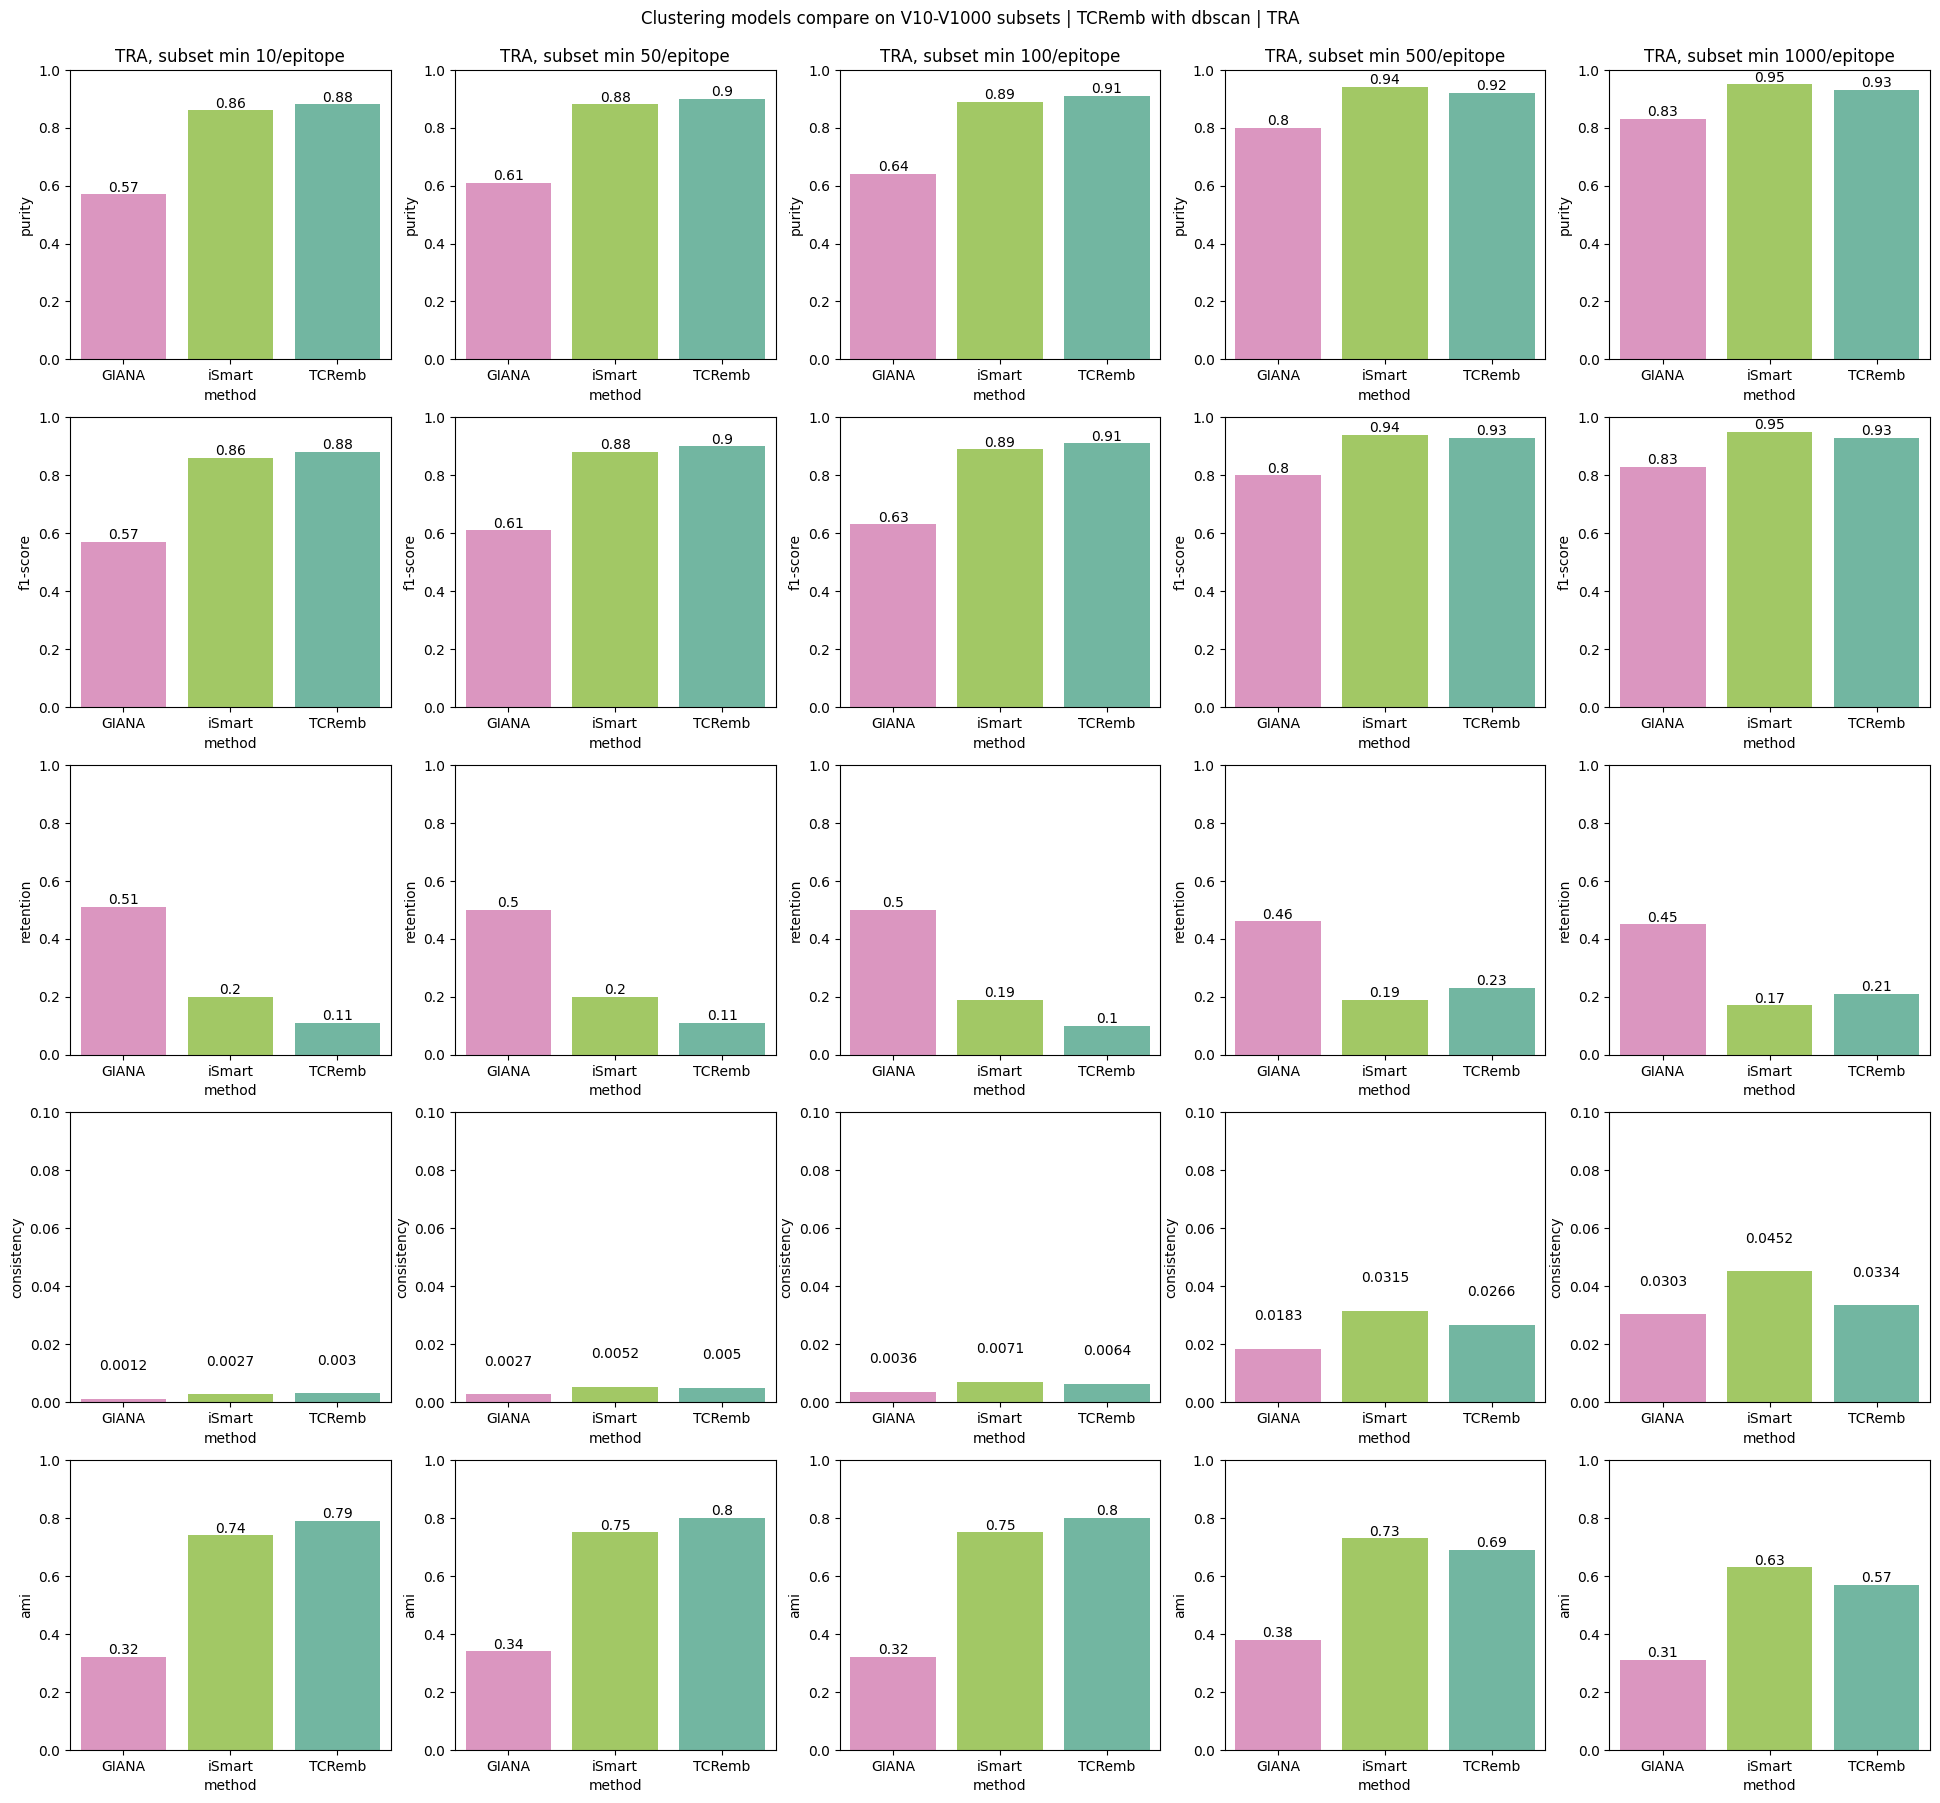

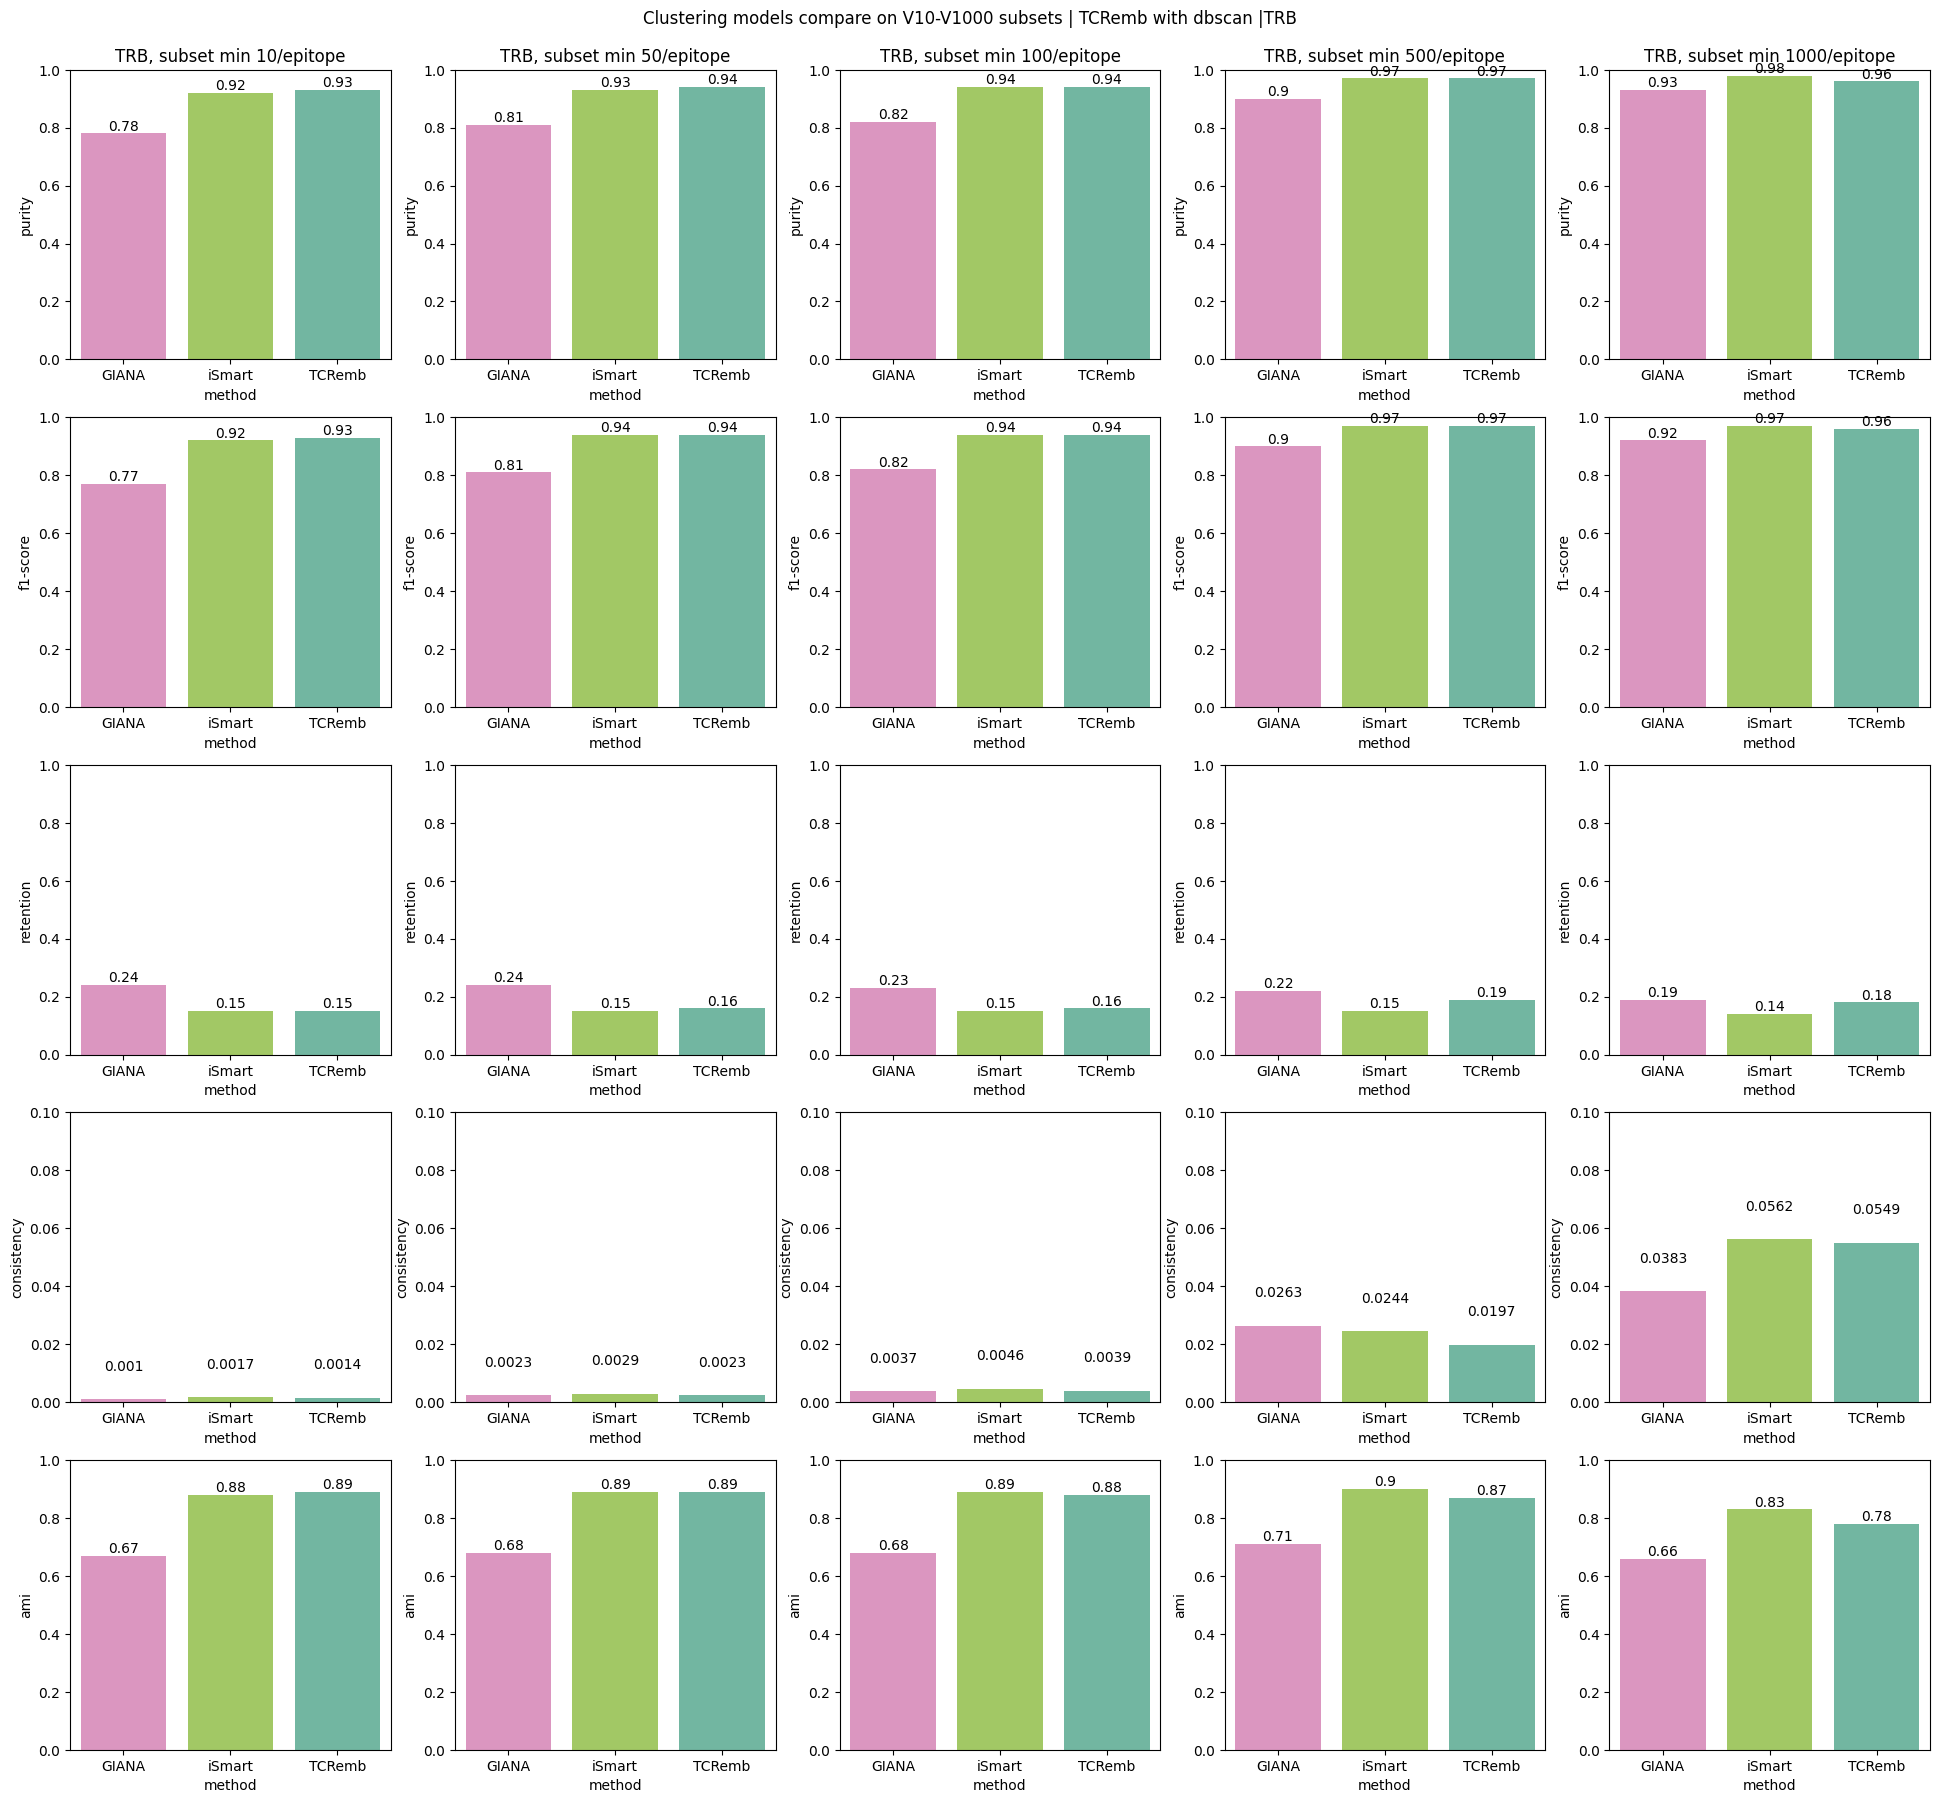

In [26]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

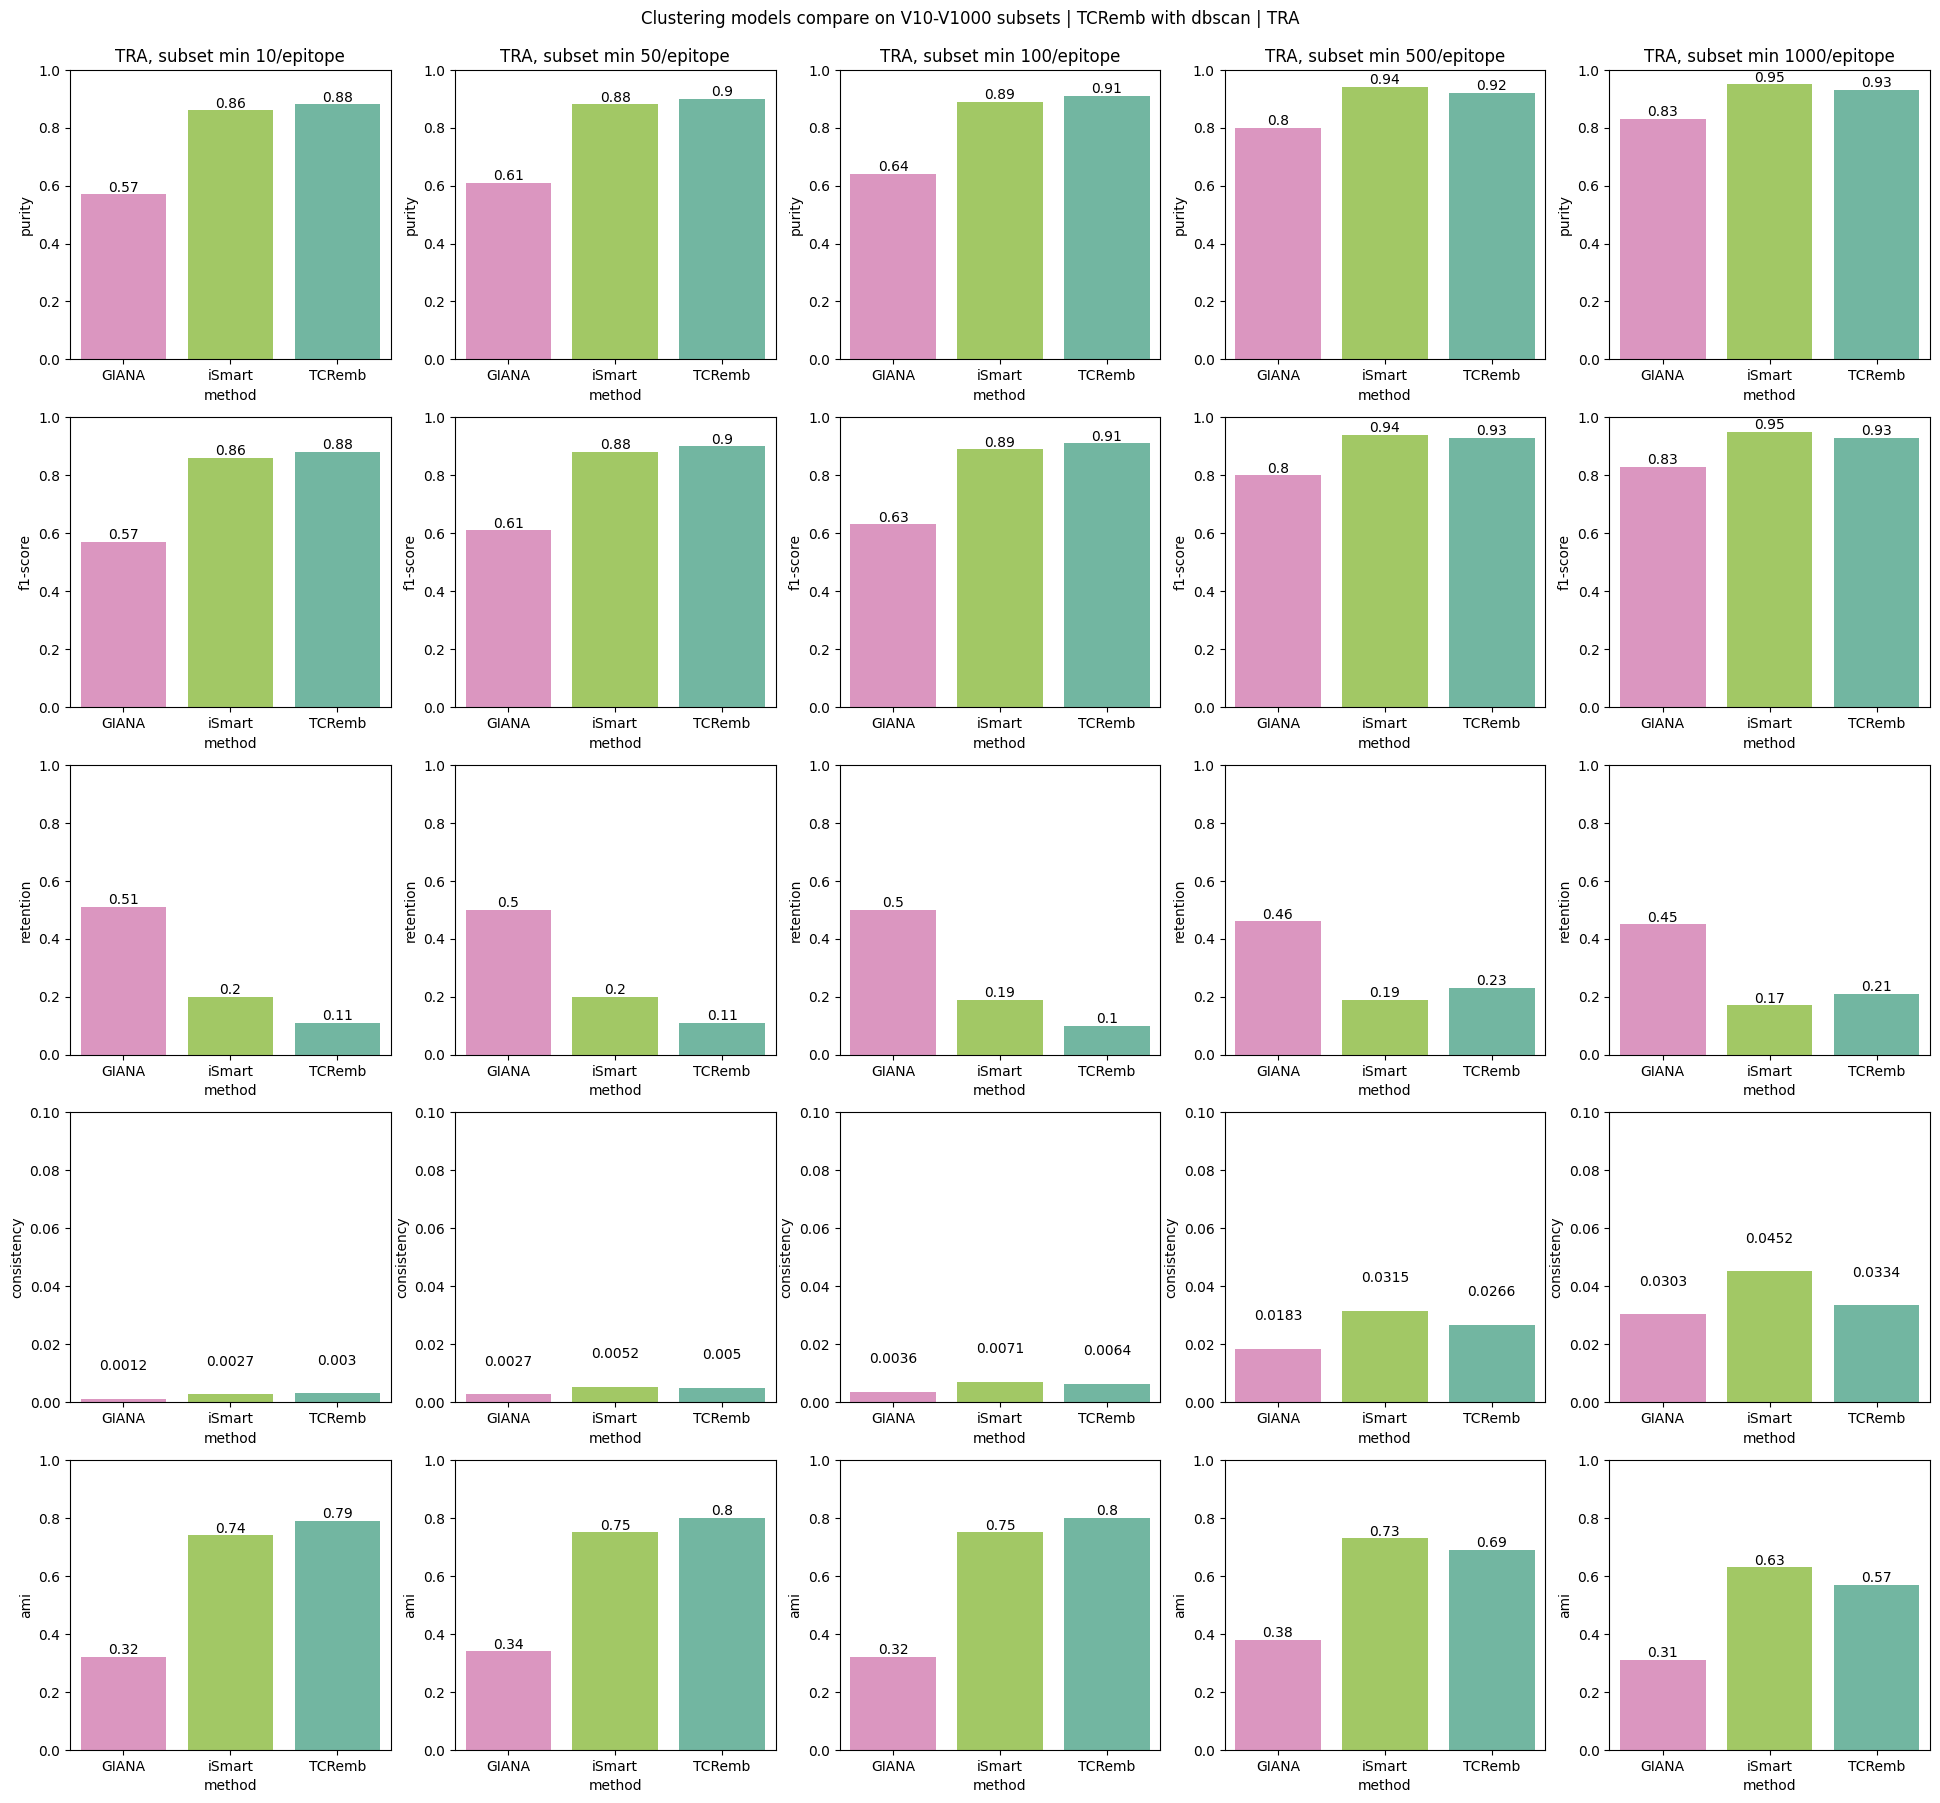

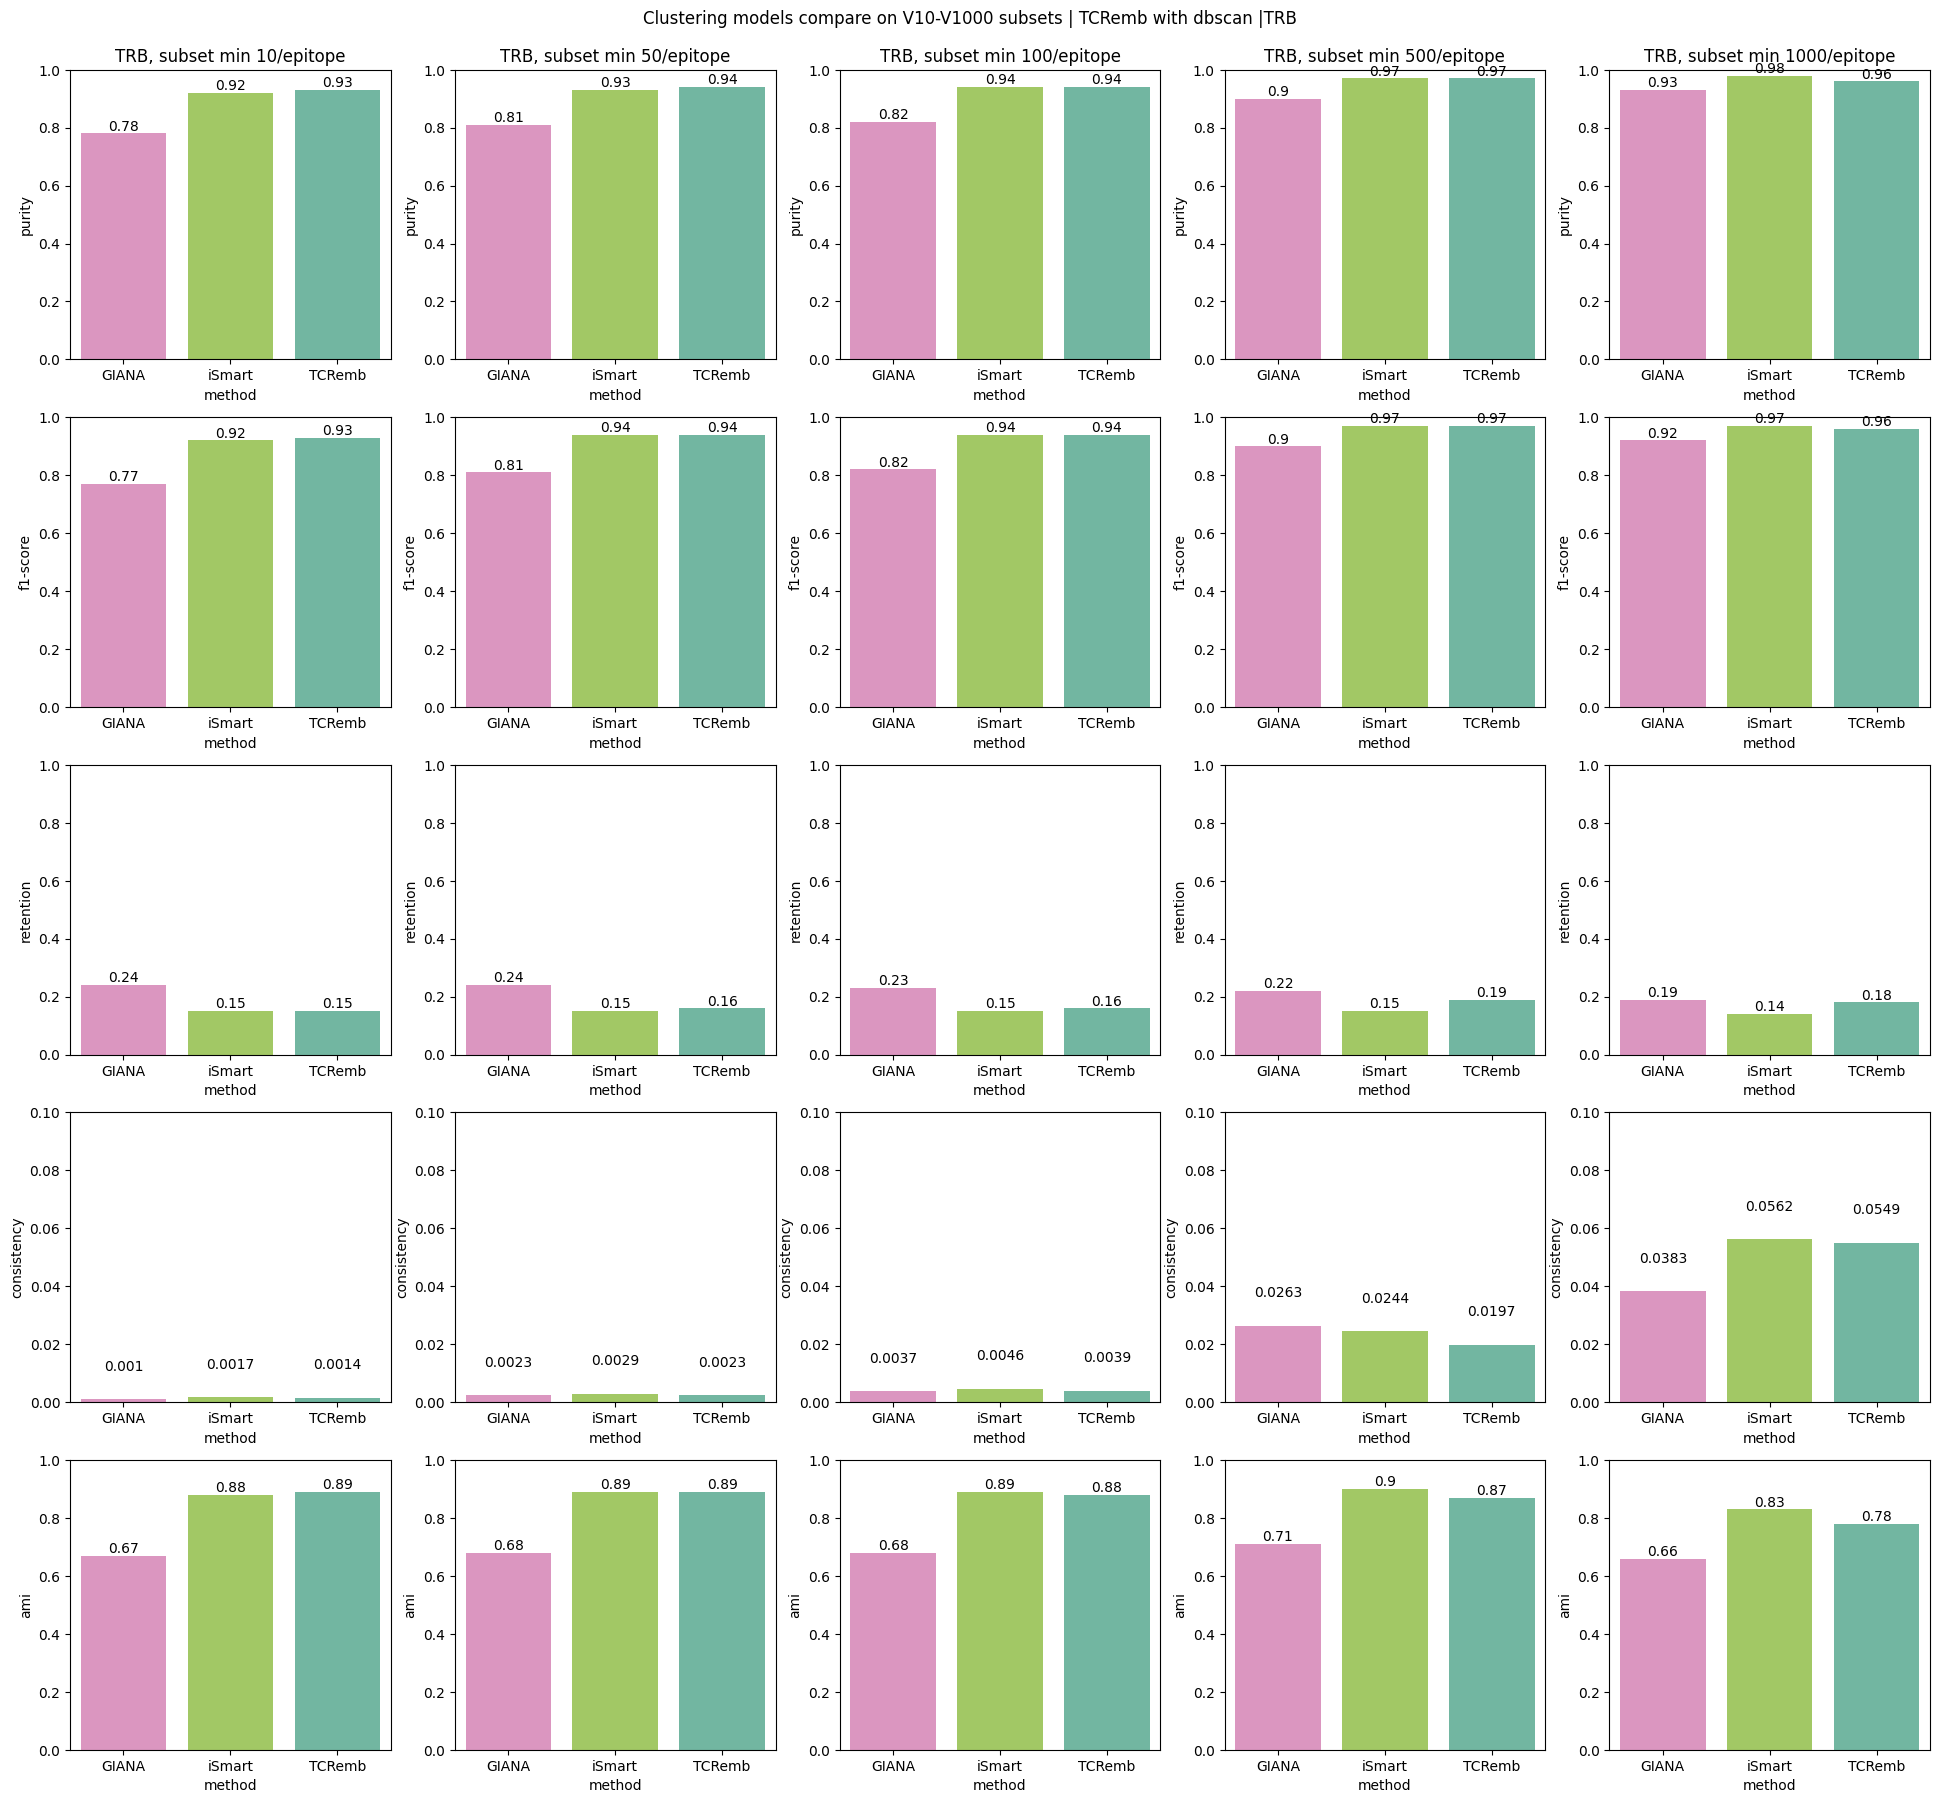

In [23]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
#plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
#plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

In [27]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)

In [24]:
## emp factor 0.75
chain='TRA'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.57,0.51,0.0012,0.32,0.57,0.57,0.57,5.03,GIANA
1,50,0.61,0.5,0.0027,0.34,0.61,0.61,0.61,4.93,GIANA
2,100,0.64,0.5,0.0036,0.32,0.63,0.64,0.63,4.84,GIANA
3,500,0.8,0.46,0.0183,0.38,0.8,0.8,0.8,4.63,GIANA
4,1000,0.83,0.45,0.0303,0.31,0.83,0.83,0.83,4.64,GIANA
5,10,0.86,0.2,0.0027,0.74,0.86,0.86,0.86,3.37,iSmart
6,50,0.88,0.2,0.0052,0.75,0.88,0.88,0.88,3.45,iSmart
7,100,0.89,0.19,0.0071,0.75,0.89,0.89,0.89,3.45,iSmart
8,500,0.94,0.19,0.0315,0.73,0.94,0.94,0.94,3.87,iSmart
9,1000,0.95,0.17,0.0452,0.63,0.95,0.95,0.95,3.82,iSmart


In [25]:
## emp factor 0.75
chain='TRB'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.78,0.24,0.001,0.67,0.77,0.78,0.77,3.64,GIANA
1,50,0.81,0.24,0.0023,0.68,0.81,0.81,0.81,3.64,GIANA
2,100,0.82,0.23,0.0037,0.68,0.82,0.82,0.82,3.75,GIANA
3,500,0.9,0.22,0.0263,0.71,0.9,0.9,0.9,4.32,GIANA
4,1000,0.93,0.19,0.0383,0.66,0.92,0.93,0.92,4.04,GIANA
5,10,0.92,0.15,0.0017,0.88,0.92,0.92,0.92,3.64,iSmart
6,50,0.93,0.15,0.0029,0.89,0.94,0.93,0.94,3.69,iSmart
7,100,0.94,0.15,0.0046,0.89,0.94,0.94,0.94,3.86,iSmart
8,500,0.97,0.15,0.0244,0.9,0.97,0.97,0.97,4.5,iSmart
9,1000,0.98,0.14,0.0562,0.83,0.97,0.98,0.97,4.85,iSmart


In [29]:
## emp factor 0.7
chain='TRB'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.78,0.24,0.001,0.67,0.77,0.78,0.77,3.64,GIANA
1,50,0.81,0.24,0.0023,0.68,0.81,0.81,0.81,3.64,GIANA
2,100,0.82,0.23,0.0037,0.68,0.82,0.82,0.82,3.75,GIANA
3,500,0.9,0.22,0.0263,0.71,0.9,0.9,0.9,4.32,GIANA
4,1000,0.93,0.19,0.0383,0.66,0.92,0.93,0.92,4.04,GIANA
5,10,0.92,0.15,0.0017,0.88,0.92,0.92,0.92,3.64,iSmart
6,50,0.93,0.15,0.0029,0.89,0.94,0.93,0.94,3.69,iSmart
7,100,0.94,0.15,0.0046,0.89,0.94,0.94,0.94,3.86,iSmart
8,500,0.97,0.15,0.0244,0.9,0.97,0.97,0.97,4.5,iSmart
9,1000,0.98,0.14,0.0562,0.83,0.97,0.98,0.97,4.85,iSmart


In [23]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)

In [25]:
metrics_v['TRB']

,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.82,0.3,0.0014,0.72,0.81,0.82,0.82,5.48,GIANA
1,50,0.84,0.3,0.003,0.74,0.84,0.84,0.84,5.64,GIANA
2,100,0.86,0.29,0.0049,0.74,0.86,0.86,0.86,5.73,GIANA
3,500,0.92,0.29,0.0332,0.77,0.92,0.92,0.92,6.77,GIANA
4,1000,0.94,0.3,0.0477,0.78,0.94,0.94,0.94,7.12,GIANA
5,10,0.93,0.21,0.0023,0.89,0.93,0.93,0.93,6.13,iSmart
6,50,0.93,0.21,0.0039,0.89,0.93,0.93,0.93,6.37,iSmart
7,100,0.94,0.21,0.0061,0.89,0.94,0.94,0.94,6.64,iSmart
8,500,0.98,0.23,0.0354,0.91,0.98,0.98,0.98,7.86,iSmart
9,1000,0.98,0.24,0.0519,0.91,0.98,0.98,0.98,8.54,iSmart


In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [ ]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"results/figures/compare_methods_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [ ]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [ ]:
!pwd

In [ ]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

In [ ]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [ ]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [ ]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [ ]:
#atm_e = atm_e[atm_e['bind']==1]

In [ ]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [ ]:
roc_res


In [ ]:
atm_e[atm_e['pred'].isna()]